<a href="https://colab.research.google.com/github/AMEERKOTTA/hands_on_machine_learning_with_sklearn_keras_and_tensorflow/blob/main/Intro%20to%20Tensorflow%20for%20Deep%20Learning/07-Time%20Series%20Forecasting/03_moving_average_forecasting_for_time_series_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MOVING AVERAGE FORECAST METHOD FOR TIME SERIES DATA**

Another Simple Method to Forecast si to Compute the Moving Average of the Series.
+ That is Mean of the Last N values.
+ This nicely Eliminates Noise.
+ But it does not anticipate Trend or Seasonality.
+ So it is Performing Worst than Naive Forecasting.
+ Here we are getting 7.1 MAE.
+ To fix that Remove the Trend and Seasonality.
+ Using the Method Called Differencing.

DIFFERENCING : Instead of Studying the Time Series itself, we study the Difference between the value of time (t) and the value one year Earlier.

> *DIFFERENCING : Instead of Studying the Time Series itself, we study the Difference between the value of time (t) and the value one year Earlier.
`Series(t) - Series(t-365)`*

+ There will be no trend and seasonality in that.
+ We then use a Moving Average Forecast in that resulting Series.

To get the Complete Forecast, Add Seasonality and Trend Back.
`Forecasts = Moving Average of Differenced Series + Series(t - 365)`

This will give the MAE = 5.8. Slightly Better than Naive Forecast.

But even after, there will be Noise. The noise will be coming from the Past Series. So we remove that as well by Applying the MA to the Past Series.

`Forecasts = Trailing Moving Avergae Differenced Series + Centered Moving Average of the Past Series (t - 365)`

This will give 4.6 MAE


***

Errors are Calculated by `errors = forecasts - actual`

METRICS need to use to Check the Perfomance of the Forecasts are


1. Mean Squared Error : `mse = np.square(errors).mean()`
2. Mean Absolute Error : `mae = np.abs(errors).mean()`
3. Mean Absolute Percentage Error : `mape = np.abs(errors/x_valid).mean()`

If the Errors are large then Use MSE and if the Errors are Small, then use MAE.

Mean Absolute Percentage Error `(mape)` : This gives the Idea of Size of the Errors Compared to the Values.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

SEASONALITY AND TREND

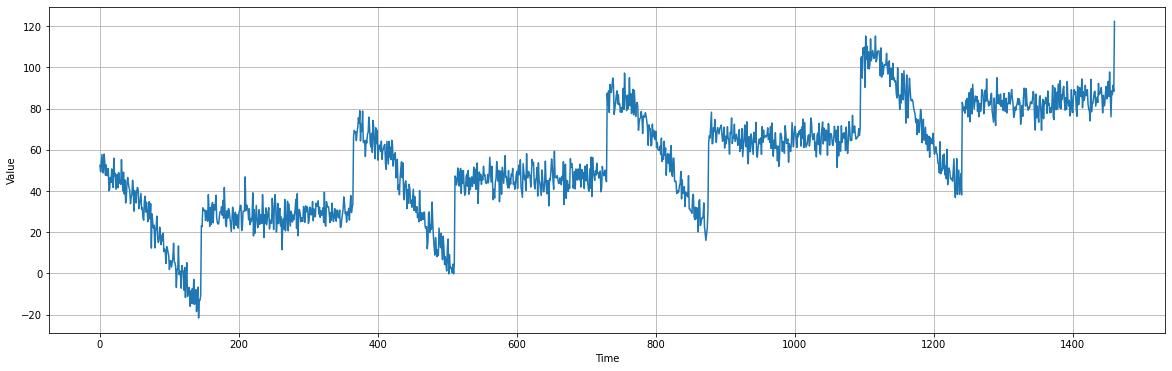

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(20, 6))
plot_series(time, series)
plt.show()

NAIVE FORECAST METHOD

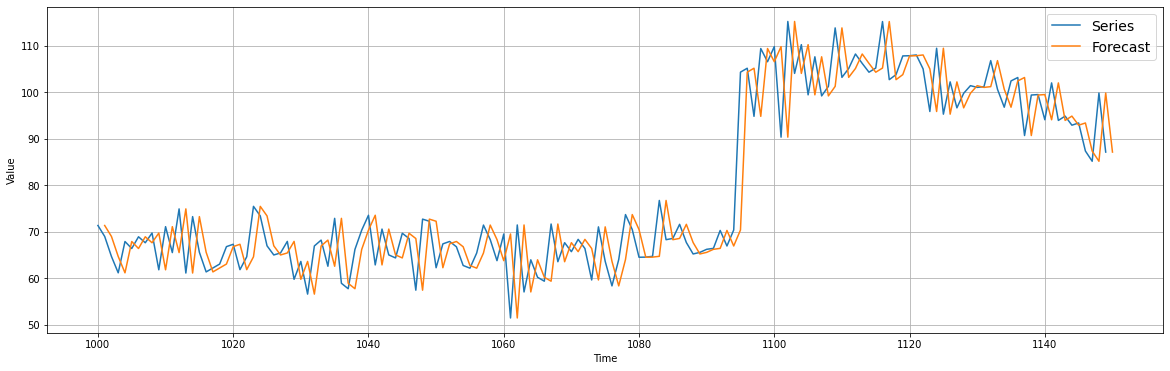

In [7]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## naive forecasting
naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

PERFOMANCE

Compute the mean absolute error between the forecasts and the predictions in the validation period:

In [8]:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.9379085153216735

`NAIVE FORECAST MAE : 5.9`

**MOVING AVERAGE FORECASTING METHOD**

In [9]:
## function to define the moving average
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

## another function to define moving average
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

(461,)


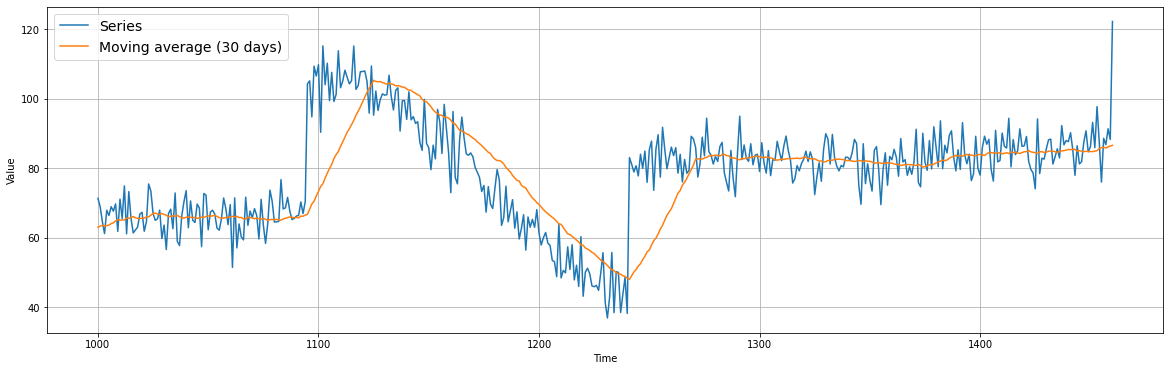

In [19]:
## claculate the moving average
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]
print(moving_avg.shape)

plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [20]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.142418570620786

`MOVING AVERAGE MEA : 7.1`

That's worse than naive forecast! 

+ The moving average does not anticipate trend or seasonality, 
+ so let's try to remove them by using differencing. 
+ Since the seasonality period is 365 days, 
+ we will subtract the value at time t – 365 from the value at time t.

(1096,)


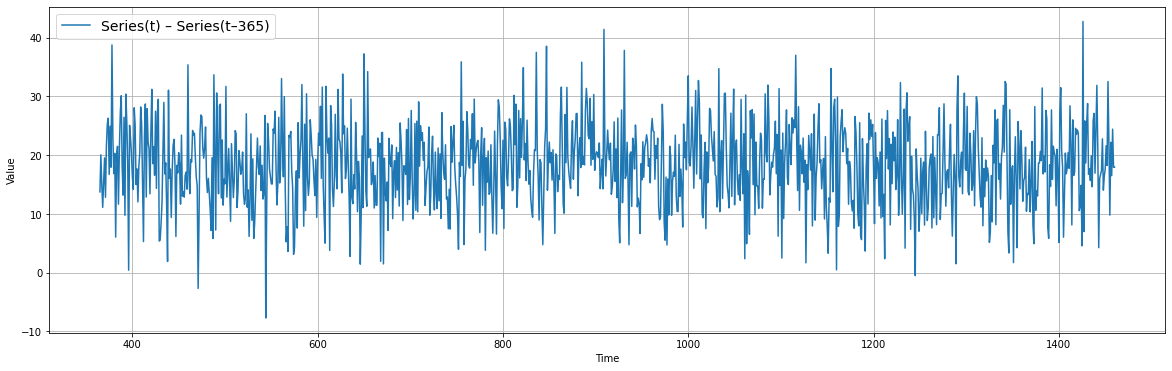

In [22]:
## using differencing
diff_series = (series[365:] - series[:-365])
print(diff_series.shape)
diff_time = time[365:]

plt.figure(figsize=(20, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

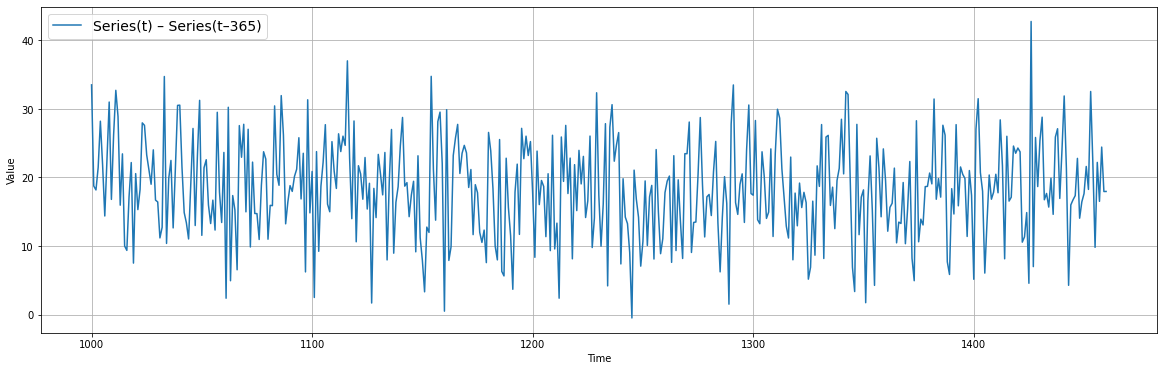

In [23]:
## focus on the validation period
plt.figure(figsize=(20, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()

In above figure, the trend and seasonality seem to be gone, so now we can use the moving average:

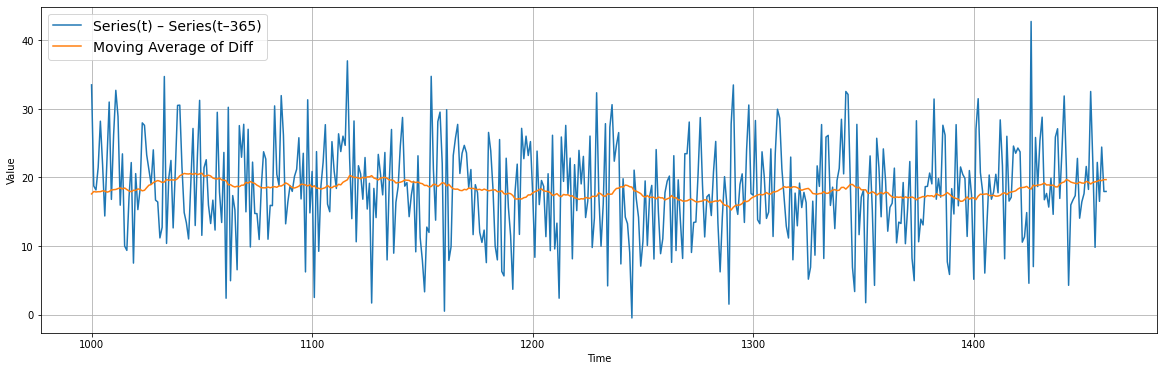

In [25]:
## computing th emoving average again
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(20, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

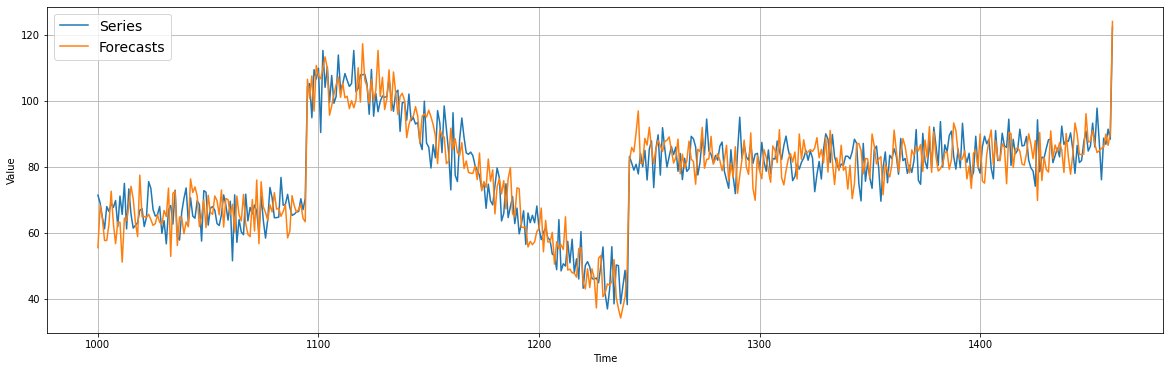

In [26]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [27]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

5.8393105629958955

`AFTER DIFFERENCING MOVING AVERAGE MAE : 5.8`

Just better than Naive Forecast.

+ Forecasts look a bit too random, because we're just adding past values, which were noisy. 
+ Let's use a moving averaging on past values to remove some of the noise

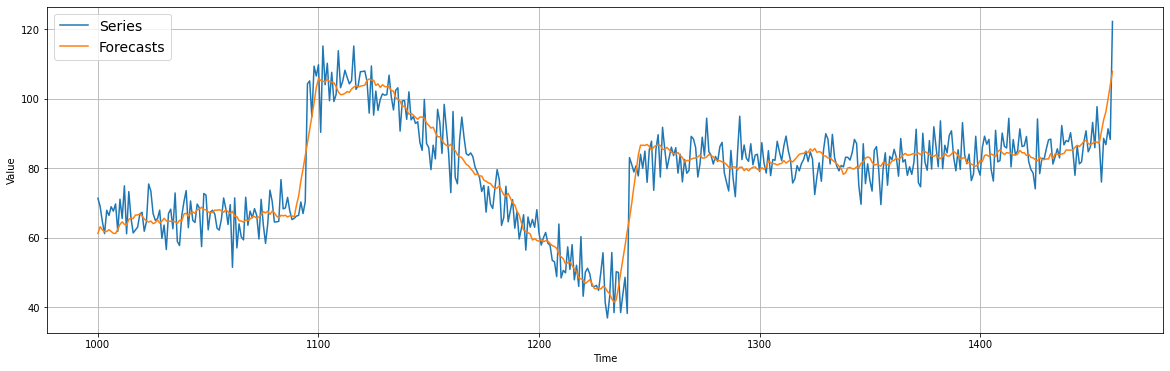

In [28]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [29]:
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

4.566859958970771

`AFTER SMOOTHING, MOVING AVERAGE MAE - 4.5`

This the Best We can get Using Moving Average Forecasting.

***